# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [4]:
# Run this to use from colab environment

import zipfile
import os
import pandas as pd

#with zipfile.ZipFile('ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
#    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


T-TESTING

Below I tried to find ways to separate our data in classes based on the features. 

First, the p-values for all features were determined to find the features with the highest significant difference between the classes. These are visualised. The 2 features with the lowest p-value were plotted against eachother in a scatterplot, but showed no seperability between the classes. 

Secondly, a PCA was performed. 

     feature    t_stat       p_value
3814    5_64  6.728289  6.223523e-11
3831    5_81  6.776686  6.728404e-11
64      0_64  6.156559  1.866903e-09
90      0_90  6.155961  1.954069e-09
81      0_81  6.149412  2.037904e-09
...      ...       ...           ...
2120   2_620  0.002408  9.980796e-01
7727  10_227 -0.001911  9.984767e-01
4656   6_156  0.001856  9.985215e-01
1805   2_305  0.000842  9.993290e-01
1355   1_605 -0.000639  9.994905e-01

[9000 rows x 3 columns]
Number of features with p-value < 0.05: 1204


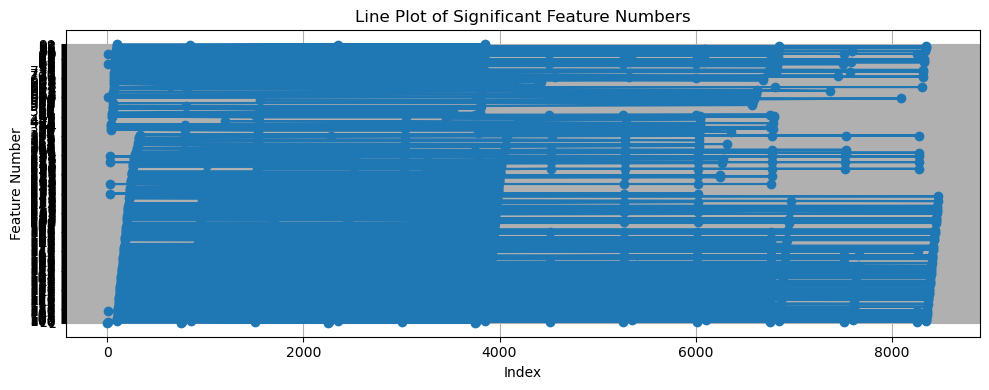

C:\Users\20ast\AppData\Local\Temp\ipykernel_34540\1821487200.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


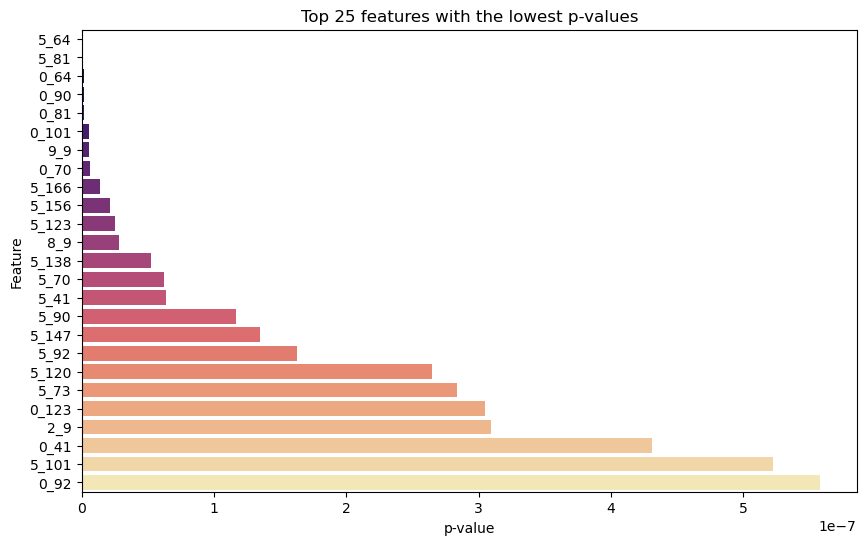

The features with the lowest p-values are: 5_64 and 5_81


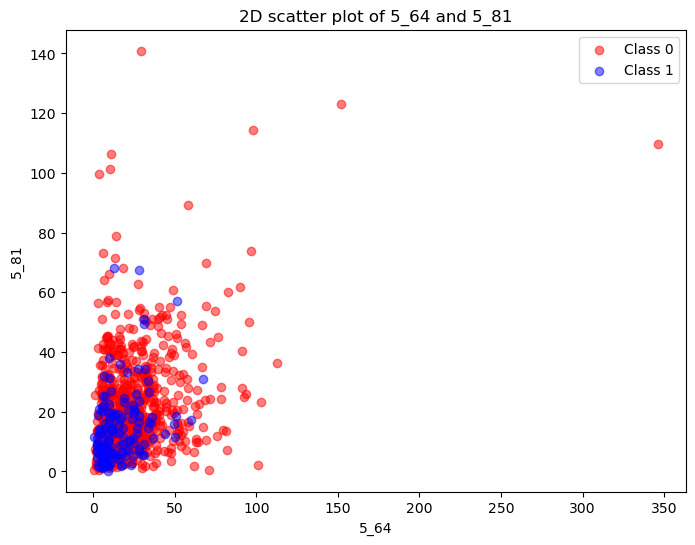

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# print(data.head())

# Split data by class
class0 = data[data['label'] == 0]
class1 = data[data['label'] == 1]

# Remove the 'label' column before performing t-tests
class0 = class0.drop(columns=['label']) 
class1 = class1.drop(columns=['label'])

# Perform t-test for each feature
t_stats, p_values = ttest_ind(class0, class1, axis=0, equal_var=False)

# Create a DataFrame to store the results
results = pd.DataFrame({'feature': data.columns[:-1],
                        't_stat': t_stats,
                        'p_value': p_values})

# Sort the results by p-value
results_sorted = results.sort_values('p_value')
print(results_sorted)
p_below_0_05 = results_sorted[results_sorted['p_value'] < 0.05]
print(f'Number of features with p-value < 0.05: {len(p_below_0_05)}')

# Save significant features to a CSV file
significant_features = p_below_0_05['feature']
cleaned_features = significant_features.str.replace(r'^.*_', '', regex=True)
cleaned_features = cleaned_features.sort_values()


cleaned_features.to_csv('significant_features.csv', index=False)


n = 25
top_features = results_sorted.head(n)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_features['p_value'],
    y=top_features['feature'],
    palette='magma'
)
plt.xlabel('p-value')
plt.ylabel('Feature')
plt.title(f'Top {n} features with the lowest p-values')
plt.show()

best_features = results_sorted['feature'].head(2).values
feat1, feat2 = best_features
print(f'The features with the lowest p-values are: {feat1} and {feat2}')
plot_data = data[[feat1, feat2, 'label']]

plt.figure(figsize=(8,6))
colors = {0: 'red', 1: 'blue'}

for label in plot_data['label'].unique():
    subset = plot_data[plot_data['label'] == label]
    plt.scatter(subset[feat1], subset[feat2], c=colors[label], label=f'Class {label}', alpha=0.5)

plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title(f'2D scatter plot of {feat1} and {feat2}')
plt.legend()
plt.show()


PCA ANALYSIS

Below, a PCA analysis was performed to improve class separation with dimensionality reduction. PCA shows directions of highest variance, which mat help find structure in the classes and separation of these classes. 

In the scatter plot, each dot is a sample. The x and y axis contain new features (PC1 en PC2) that represent directions of maximum variance in the data. If the classes are clustered seperately (they are not), it means PCA captured some separability. 

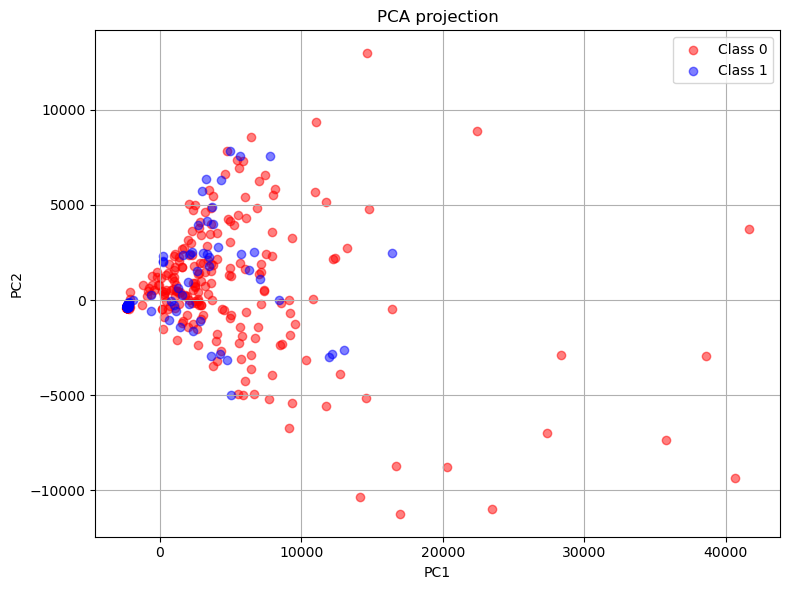

In [31]:
from sklearn.decomposition import PCA

features = data
y = data['label']

pca = PCA(n_components=2)
x_pca = pca.fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[y == 0, 0], x_pca[y == 0, 1], c='red', label='Class 0', alpha=0.5)
plt.scatter(x_pca[y == 1, 0], x_pca[y == 1, 1], c='blue', label='Class 1', alpha=0.5)
plt.title('PCA projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The plot above shows overlap in classes. This can mean that the directions of highest variance (which PCA uses) are not aligned with the directions that best separate the classes. Or the data is nonlinear in nature and PCA (a linear method) can't capture the true structure. 

Because we have many features (9001), many are likely irrelevant. That's why I will try to reduce the feature space before performing PCA. 

In [ ]:
selected_features = results_sorted['feature'].head